My model uses customer and product data to generate a lookalike recommendation system based on similarity scores. It preprocesses the data by aggregating transaction and customer information, one-hot encoding categorical variables, and normalizing features. A KNN model is trained on the processed data to find the top 3 most similar customers for each of the first 20 customers. The results are formatted as Map<cust_id, List<cust_id, score>> and saved in Lookalike.csv, where each row corresponds to one customer and their top 3 lookalikes with similarity scores.

Davies-Bouldin Index: 0.9578205962311453


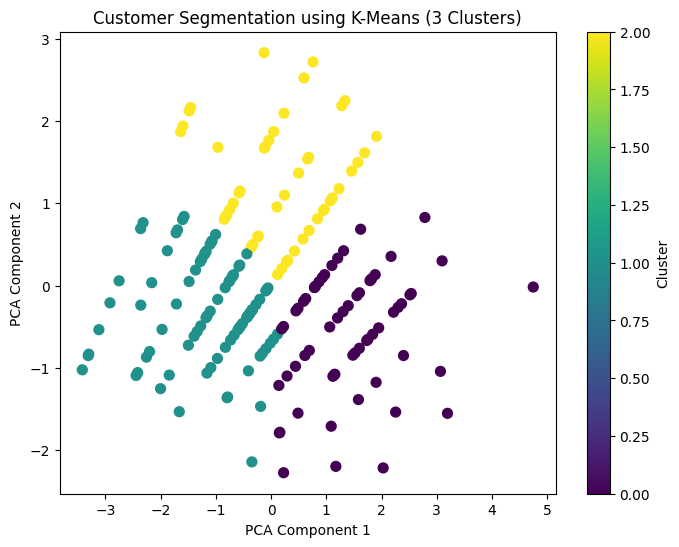

In [55]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score

download_url = f"https://drive.google.com/uc?id=1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE"
customers  = pd.read_csv(download_url)

download_url = f"https://drive.google.com/uc?id=1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0"
products  = pd.read_csv(download_url)

download_url = f"https://drive.google.com/uc?id=1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF"
transactions = pd.read_csv(download_url)

# Merge the datasets on 'CustomerID'
data = transactions.merge(customers, on='CustomerID')

# Feature Engineering: Aggregate transaction data by customer
customer_summary = data.groupby('CustomerID').agg(
    total_spending=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean')
).reset_index()

# Merge the customer features with the original profile data
customer_data = customer_summary.merge(customers, on='CustomerID')

# Select relevant features for clustering
features = ['total_spending', 'transaction_count', 'avg_transaction_value']

X = customer_data[features]

# Handle missing data by filling with zero
X = X.fillna(0)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means Clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Calculate the Davies-Bouldin Index (DB Index)
db_index = davies_bouldin_score(X_scaled, customer_data['Cluster'])

# Print the DB Index
print(f'Davies-Bouldin Index: {db_index}')

# Visualization using PCA for 2D plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters in 2D space
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=customer_data['Cluster'], cmap='viridis', s=50)
plt.title('Customer Segmentation using K-Means (3 Clusters)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()
